## Setup, Loading Data and CDFs

In [23]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [24]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_full_agriVision.ipynb


In [25]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)
assert CWD == os.getcwd()

Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/diagonal/gray'

In [26]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [27]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [28]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4500,
 3: 18000,
 4: 72000,
 5: 288000,
 6: 1152000,
 7: 4608000,
 8: 18432000,
 9: 73728000,
 10: 294912000}

Running 12721 CDFs


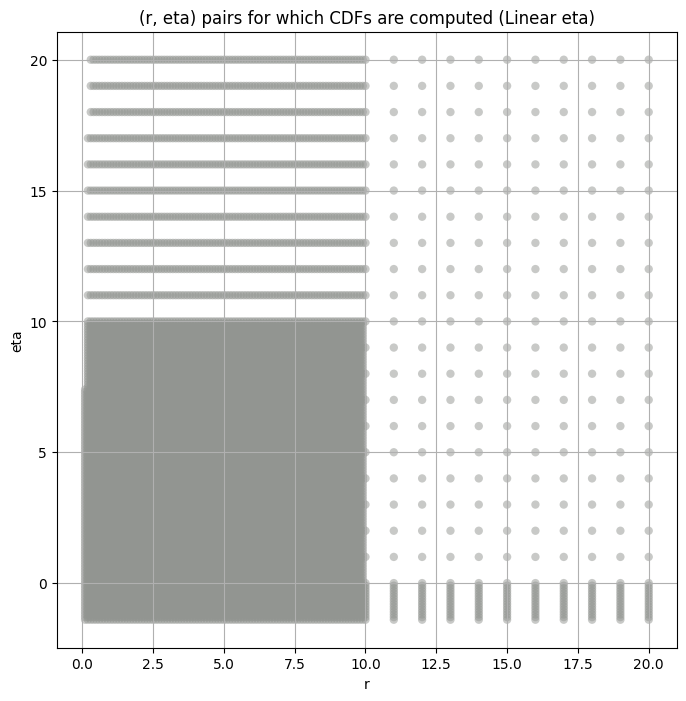

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [ ]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df[~all_cdfs_df['kurtosis'].isna()]
all_cdfs_df = all_cdfs_df[~(all_cdfs_df['kurtosis'] == np.inf)]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);

all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [30]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [ ]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    #master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

#master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df


Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2      49450.980000  19202.867000  101513.000000   500.58080   93.005810   
3       8568.368000   4678.516000   14358.227000   487.67252  163.083920   
4       1787.585200    838.502750    3350.636500   762.55035  170.148350   
5        284.274750    138.199070     671.343440  1228.92970   86.793030   
6         70.411040     35.697952     185.533100  1638.79710   65.571650   
7         23.222046     12.280906      72.200690  2538.97050   51.936737   
8          9.512077      4.864893      27.376392  1990.12560   68.890760   
9          1.696372      0.967391       4.156639  1298.78150   67.881310   
10         0.181317      0.080193       0.812861  5574.85640   78.470020   

       kurt_upper  total_samples  
layer                             
2       851.76105         4500.0  
3       789.38290        18000.0  
4      1375.01650        72000.0  
5      3410.60180       288000.0  
6      3892.75050      1152000.0  
7      4483.44800      4608000.0  
8      4263.74560     18432000.0  
9      3193.16480     73728000.0  
10     6336.02300    294912000.0

## Initial Grid Search and Hypothesis Test Plots

In [32]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [33]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      49450.980000   49450.980469     8567.621094     6782.843750   
3       8568.368000    8568.368164     2502.127197     2043.140503   
4       1787.585200    1787.585205      768.700623      597.265198   
5        284.274750     284.274750      142.886078      120.357635   
6         70.411040      70.411041       37.032257       31.964481   
7         23.222046      23.222046       12.749860       11.209029   
8          9.512077       9.512077        5.095488        4.380235   
9          1.696372       1.696372        1.015996        0.874835   
10         0.181317       0.181317        0.084603        0.071797   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5650.314453      4890.156738      3824.677734      3097.633545   
3         1782.679199      1609.879761      1375.509644      1209.377686   
4          519.176636       472.828125       415.471863       376.292114   
5          108.626266       100.498528        89.893845        82.792633   
6           29.212294        27.365221        24.979393        23.380512   
7           10.349060         9.771373         8.996522         8.475763   
8            3.985188         3.723282         3.387993         3.173325   
9            0.795762         0.743650         0.676435         0.631940   
10           0.064816         0.060294         0.054487         0.050626   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          2562.221924      2154.326172      1823.494629      1179.780518  
3          1082.169312       982.348022       899.215149       716.533875  
4           348.439117       326.577698       308.454254       267.895630  
5            77.559807        73.374283        69.955170        62.174274  
6            22.181648        21.229595        20.438040        18.658548  
7             8.088338         7.779855         7.524806         6.943770  
8             3.016775         2.893043         2.789802         2.552030  
9             0.598457         0.571386         0.548558         0.495570  
10            0.047699         0.045323         0.043313         0.038628

####
Layer  2


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 0 0.012977025542726617 49450.98


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 25 0.015869048634541916 8567.621


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 50 0.014514224847522739 6782.8438


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 75 0.02314136732763472 5650.3145


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 100 0.014417312656724302 4890.1567


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 150 0.012757926760497251 3824.6777


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 200 0.01652389509274954 3097.6335


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 250 0.016894221863185233 2562.222


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 300 0.019557741078915766 2154.3262


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 350 0.02716703185965169 1823.4946


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
2 500 0.5026666666666667 1179.7805
Number of samples: 4500, Without approximation : 4500.0


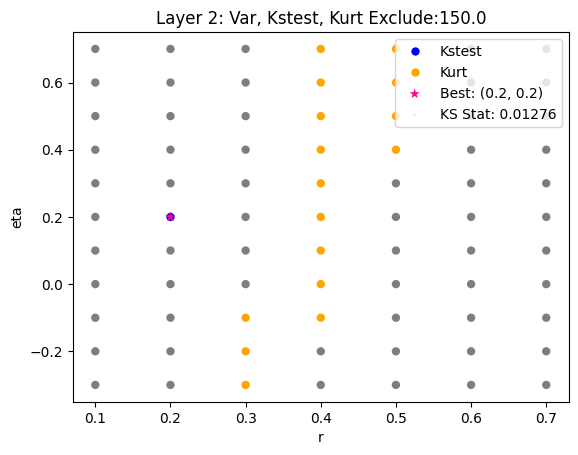

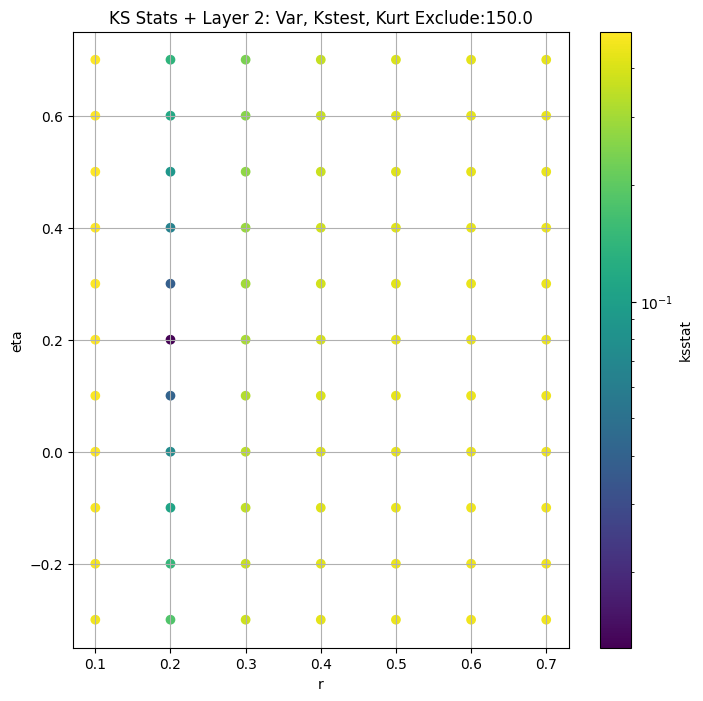

####
Layer  3


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 0 0.017255535776846798 8568.368


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 25 0.020902786009732055 2502.1272


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 50 0.021173223174878575 2043.1405


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 75 0.02415375588518287 1782.6792


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 100 0.023652149068787987 1609.8798


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 150 0.02384111432425795 1375.5096


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 200 0.02639876786529538 1209.3777


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 250 0.02619445307157864 1082.1693


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 300 0.027652648879506803 982.348


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 350 0.02005461083918736 899.21515


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
3 500 0.030642798463618615 716.5339
Number of samples: 18000, Without approximation : 18000.0


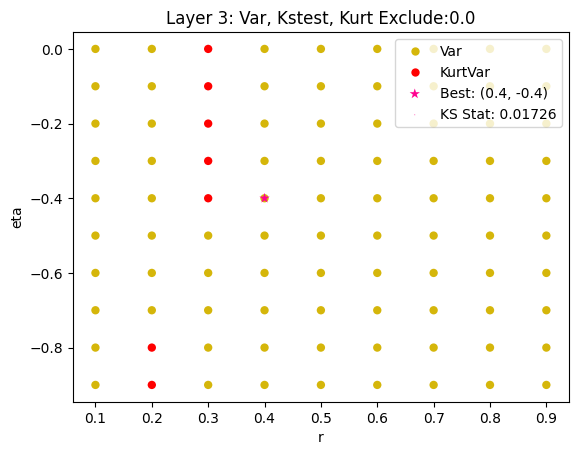

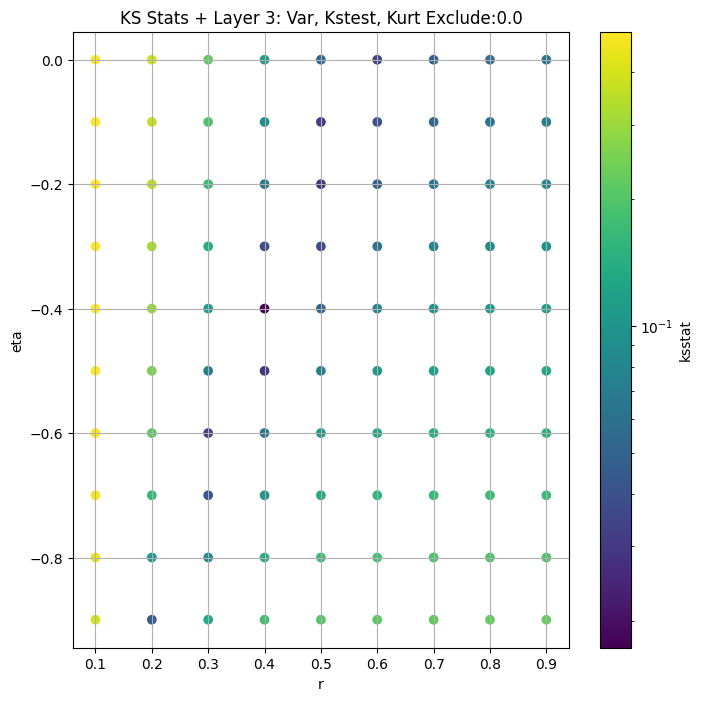

####
Layer  4


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 0 0.014807857157649235 1787.5852


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 25 0.01664999636607853 768.7006


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 50 0.018093290470257872 597.2652


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 75 0.017777282094361246 519.17664


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 100 0.019523404994360005 472.82812


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 150 0.013872954004380711 415.47186


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 200 0.017042434858023814 376.2921


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 250 0.01255993523172727 348.43912


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 300 0.020014044341778336 326.5777


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 350 0.011473148978211195 308.45425


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
4 500 0.016796850921818013 267.89563
Number of samples: 72000, Without approximation : 72000.0


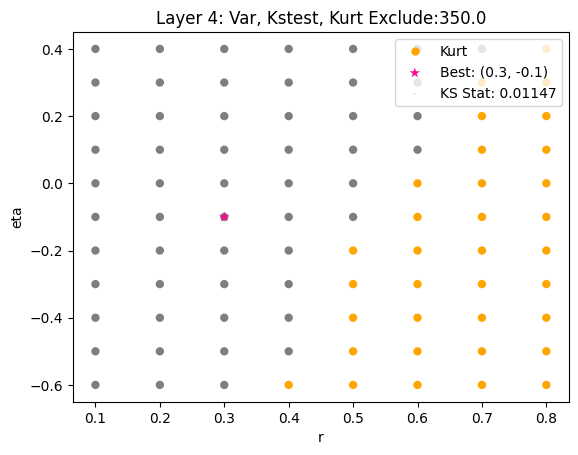

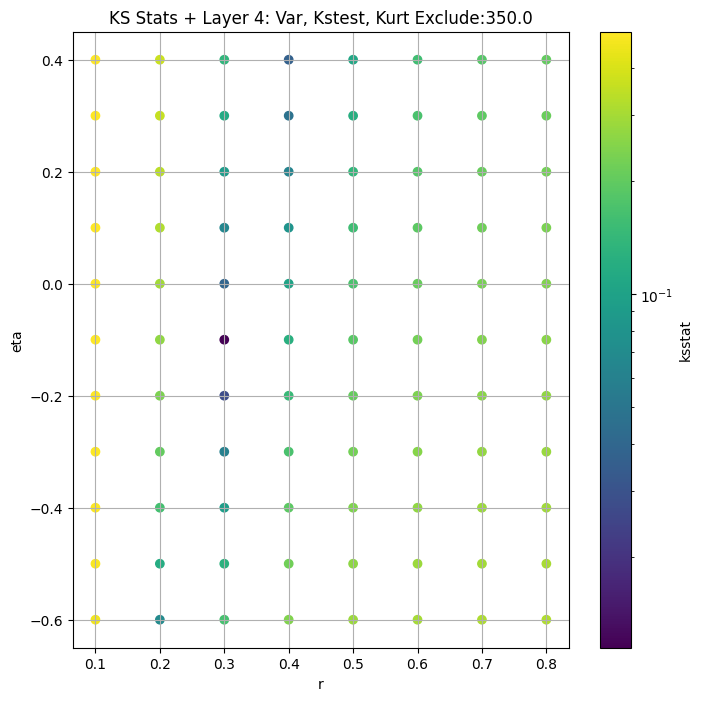

####
Layer  5


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 0 0.030592387911566266 284.27475


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 25 0.013416022588133347 142.88608


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 50 0.012294345879379462 120.357635


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 75 0.012562527493145348 108.62627


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 100 0.012313716050613488 100.49853


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 150 0.013167871756380123 89.893845


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 200 0.008072466081287977 82.79263


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 250 0.011508223734309486 77.55981


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 300 0.009670206095972578 73.37428


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 350 0.01094491342367876 69.95517


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
5 500 0.009872149088297921 62.174274
Number of samples: 100000, Without approximation : 288000.0


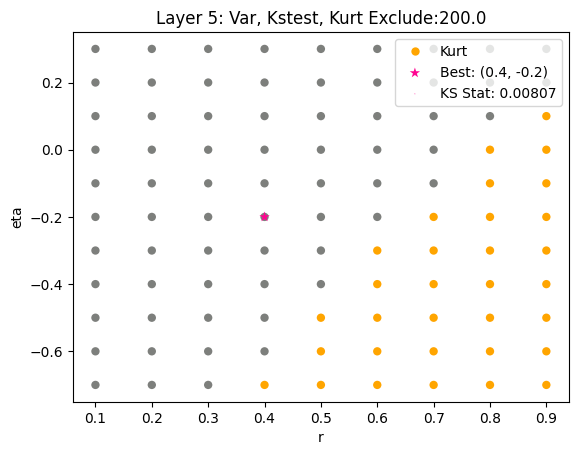

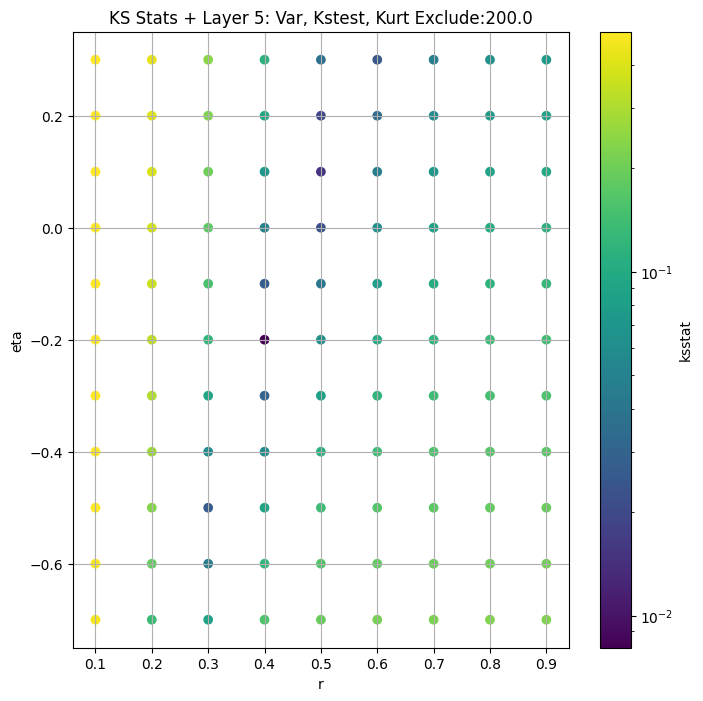

####
Layer  6


  0%|          | 0/12721 [00:00<?, ?it/s]

Finding Minimum after computing 12721 CDFs
6 0 0.049632753548491226 70.41104


  0%|          | 0/12721 [00:00<?, ?it/s]

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
            
            if exclude_cutoff == 0:
                augmented_kurt = stats.kurtosis(group_data_map[group]) 
            else:
                augmented_kurt = stats.kurtosis(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_kurt == stats.kurtosis(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_kurt / group_cdfs_df['kurtosis']), 0,  SCALE_CAP)
            #group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        #fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    #master_df.to_csv(master_df_combo_path)
    #pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    #augmented_var_df.to_csv(augmented_var_df_path)

#augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
#master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
#rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [ ]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0859794579211487, var: 431.631103515625


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.07095608885498361, var: 501.9972229003906


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05399972214197779, var: 592.0384521484375


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.033724333818647034, var: 717.9315185546875


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.011978663064072637, var: 995.5660400390625
Number of samples: 1590, Without approximation : 1590


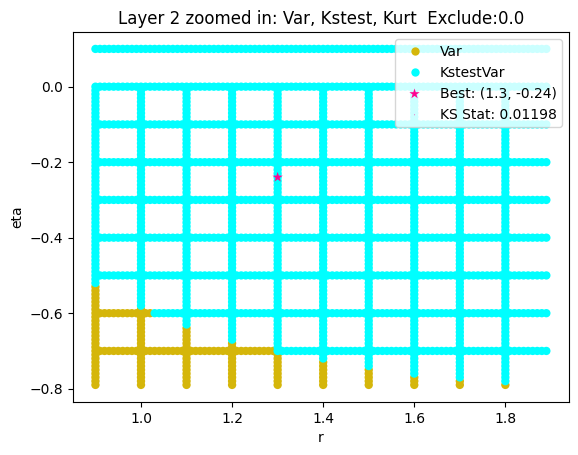

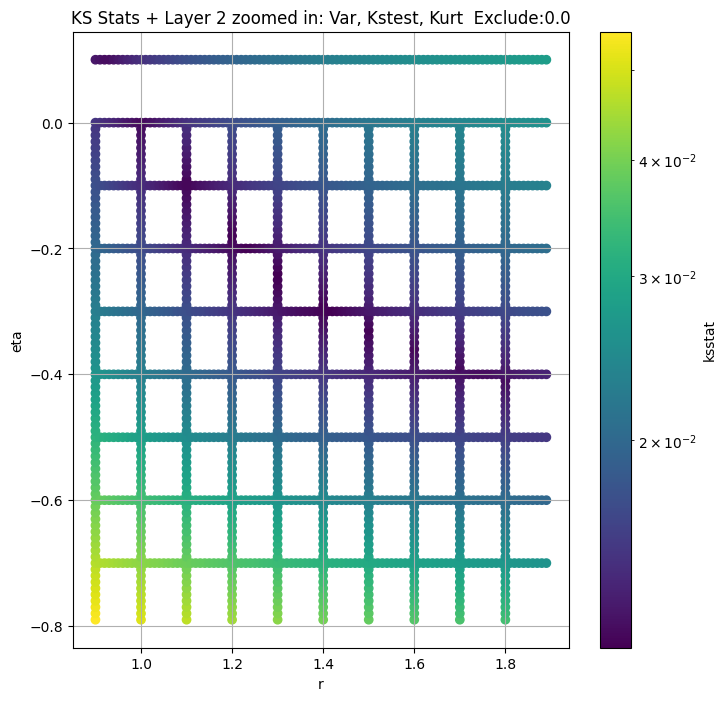

Layer 3


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.028241044512422583, var: 213.9823455810547


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02366524140907003, var: 226.81509399414062


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01840879859674098, var: 241.9077911376953


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.012851312508053492, var: 262.2912902832031


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.008148137641604603, var: 299.9889221191406
Number of samples: 6360, Without approximation : 6360


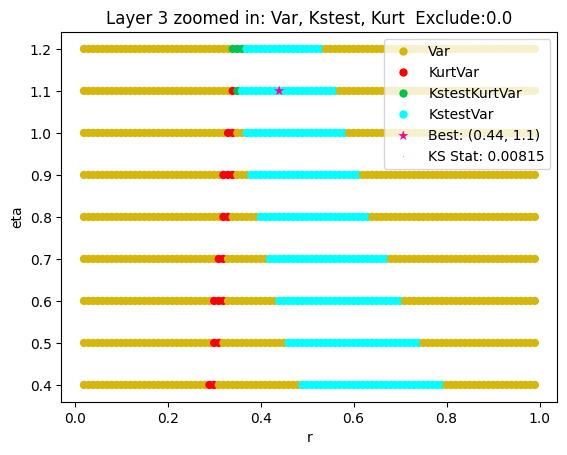

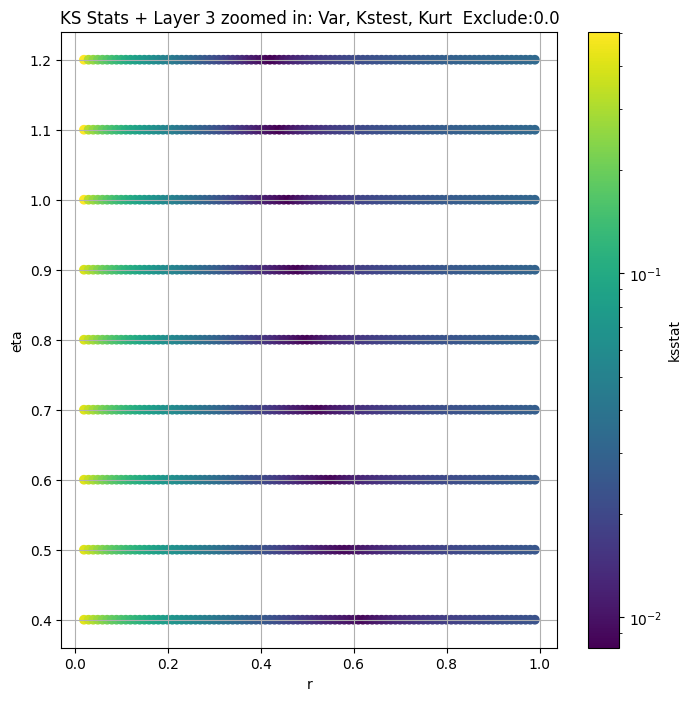

Layer 4


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.0074760702671603785, var: 65.53135681152344


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006040491084571498, var: 67.30862426757812


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.004866213245236062, var: 69.40589904785156


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.0036786109883661933, var: 71.87660217285156


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0027433526539583086, var: 75.56288146972656
Number of samples: 25440, Without approximation : 25440


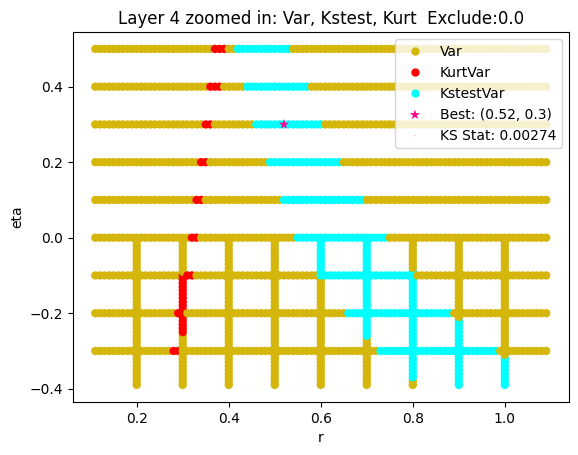

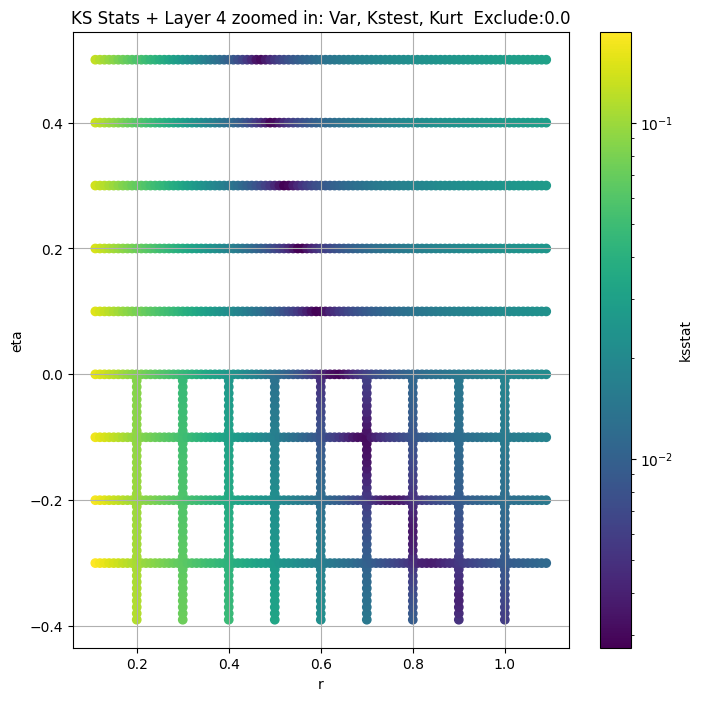

Layer 5


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.0036669353508943514, var: 13.4472074508667


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.003304649285767791, var: 13.581552505493164


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.002957308530109115, var: 13.725799560546875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.002590816840003729, var: 13.883931159973145


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.0023471092494263823, var: 14.059965133666992


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0020427353364778217, var: 14.26850414276123


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.001753397058808337, var: 14.565750122070312
Number of samples: 100000, Without approximation : 101760


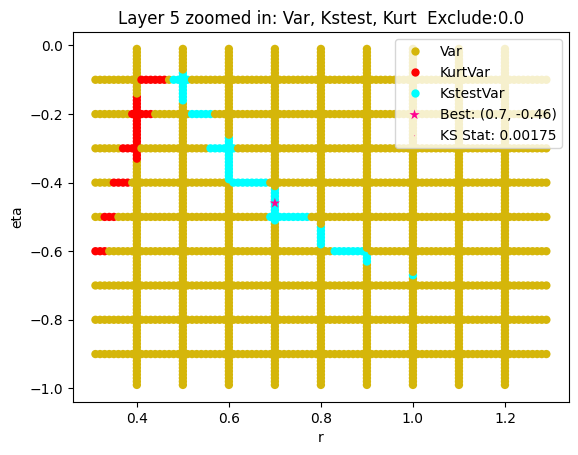

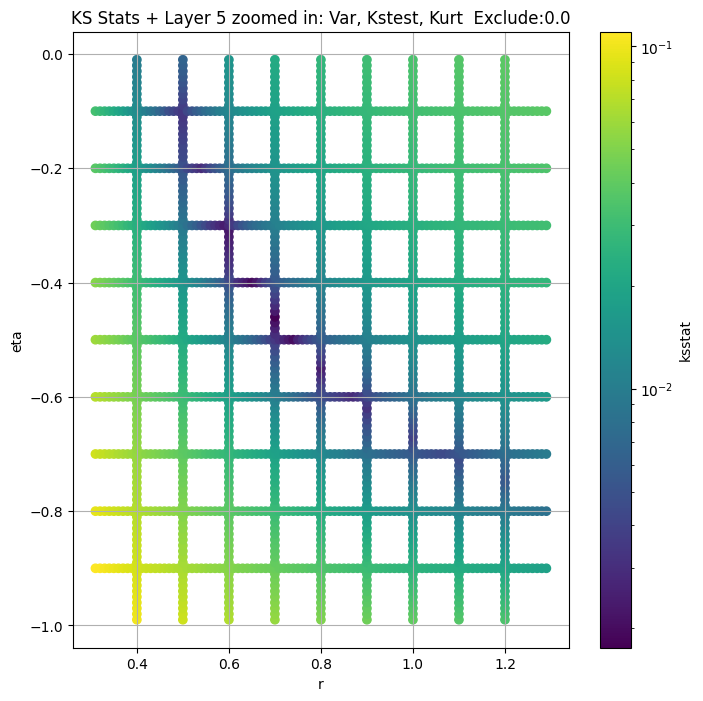

Layer 6


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 100 = 125, ksstat: 0.004694013671022512, var: 2.369234085083008


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 75 = 100, ksstat: 0.004804114850495977, var: 2.3991916179656982


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 50 = 75, ksstat: 0.0043120903204202365, var: 2.4319589138031006


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 25 = 50, ksstat: 0.004259331184461146, var: 2.4691107273101807


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 0 = 25, ksstat: 0.004071632984090745, var: 2.5131330490112305


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + -25 = 0, ksstat: 0.0038645105893608256, var: 2.5811264514923096
Number of samples: 100000, Without approximation : 407040


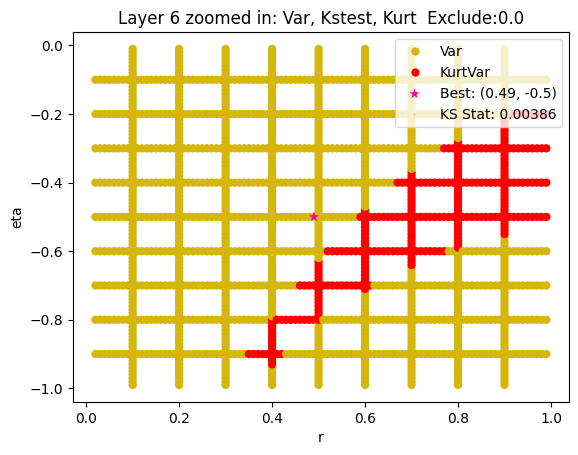

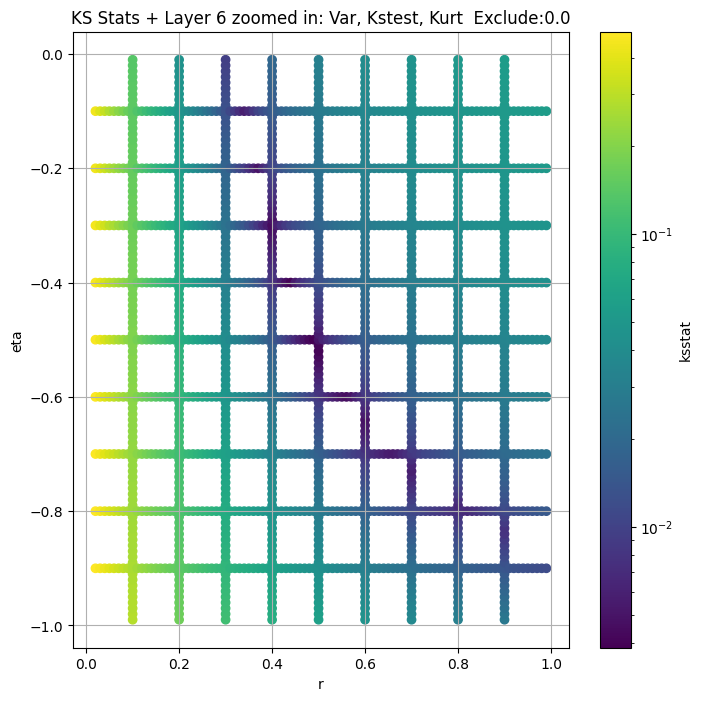

Layer 7


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.006196734595591891, var: 0.3922286927700043


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.0057719437928825945, var: 0.3985806405544281


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.005489209275417961, var: 0.4056210517883301


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.005285288172331093, var: 0.41368794441223145


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.005129187888257558, var: 0.42354199290275574


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.004638496532249681, var: 0.43972453474998474
Number of samples: 100000, Without approximation : 1628160


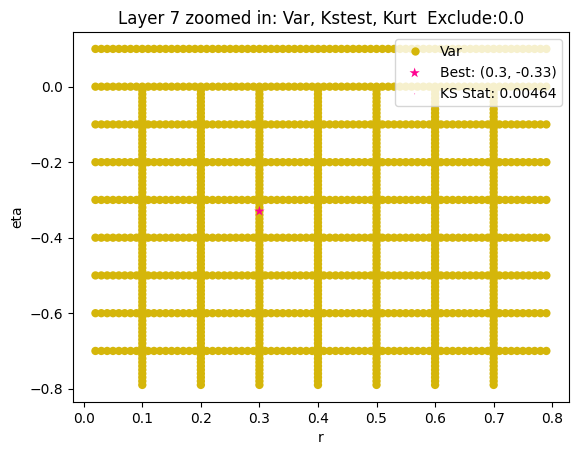

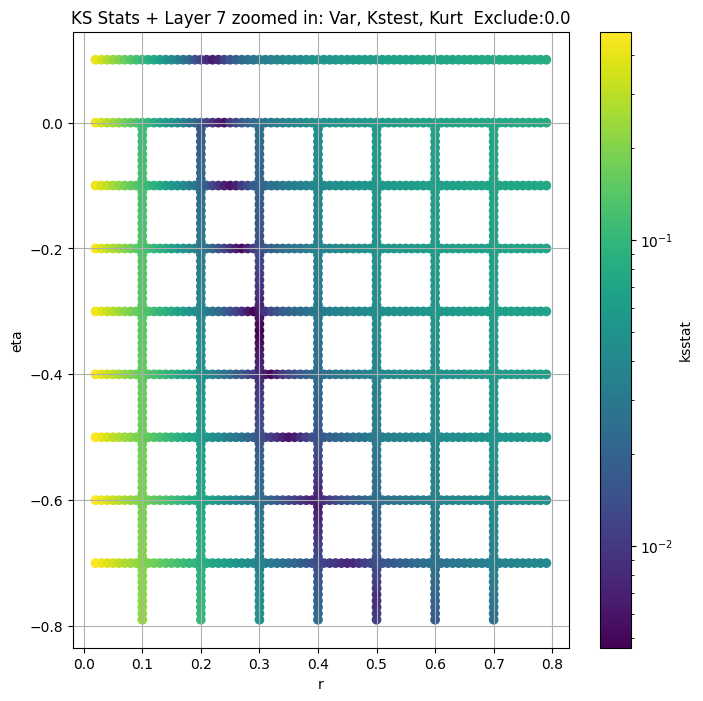

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.006468126192501367, var: 0.03907462954521179


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.005964769484944177, var: 0.039910316467285156


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.005374847926266746, var: 0.04088766872882843


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.004853145847886209, var: 0.0421183742582798


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.00446427932132254, var: 0.044586341828107834
Number of samples: 100000, Without approximation : 6512640


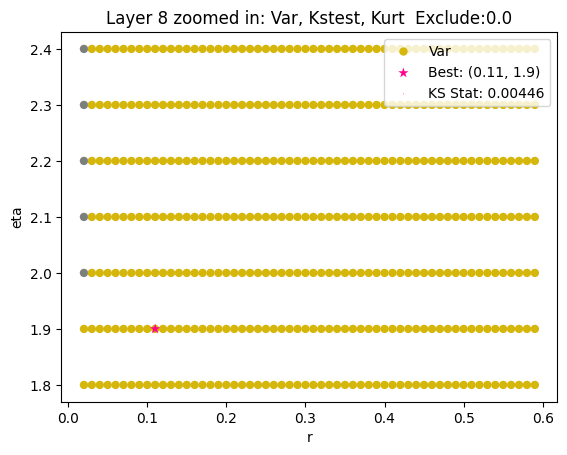

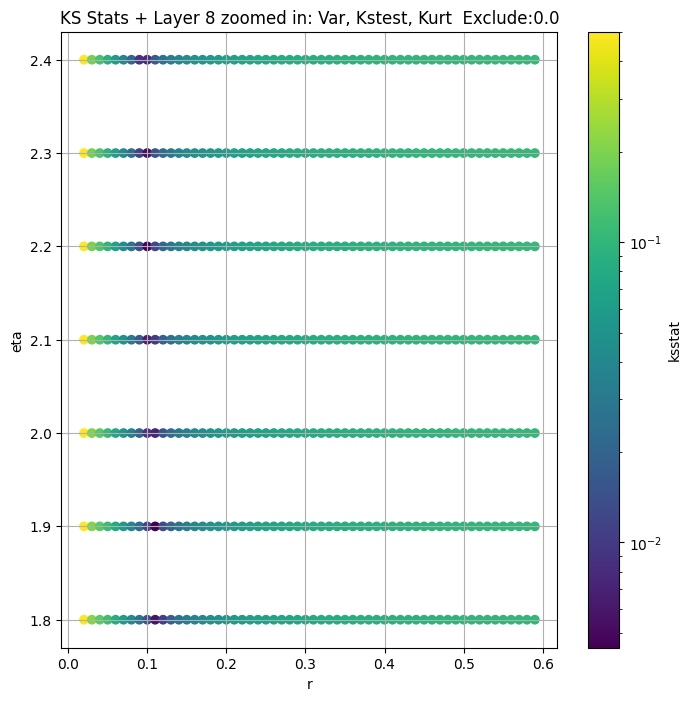

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      995.566040  864.354500  1142.784500   2.687830    1.028233    4.575933   
3      299.988920  279.984800   320.884950   2.454340    1.804920    3.180163   
4       75.562880   71.306270    80.026050   2.987251    2.351555    3.896905   
5       14.565750   13.678300    15.491117   3.872311    3.021069    4.954880   
6        2.581126    2.403492     2.771678   5.708778    4.301481    8.222433   
7        0.439725    0.403006     0.480876   9.534605    6.583607   17.606100   
8        0.044586    0.040037     0.050722  18.418106    8.617492   67.336680   

       total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                               
2               1590             0.012170        1.4         -0.3   
3               6360             0.008432        0.5          0.8   
4              25440             0.002853        0.6          0.1   
5             101760             0.002603        0.8         -0.5   
6             407040             0.004151        0.5         -0.5   
7            1628160             0.005992        0.3         -0.3   
8            6512640             0.004613        0.1          2.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.236068e+03                     0.0          995.566040   
3       1.164553e+01                     0.0          299.988922   
4       1.227684e+01                     0.0           75.562881   
5       9.586700e+00                    50.0           14.565750   
6       4.188555e-01                    25.0            2.581126   
7       1.874817e-03                    25.0            0.439725   
8       3.014167e-18                     0.0            0.044586   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033952          0.011979    1.30     -0.24   
3                     0.017003          0.008148    0.44      1.10   
4                     0.008508          0.002743    0.52      0.30   
5                     0.004256          0.001753    0.70     -0.46   
6                     0.002128          0.003865    0.49     -0.50   
7                     0.001064          0.004638    0.30     -0.33   
8                     0.000532          0.004464    0.11      1.90   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      1.106623e+03                  0.0        13578  
3      4.233649e+00                  0.0        27165  
4      5.531722e+00                  0.0       244498  
5      6.972310e+00                  0.0       579555  
6      3.948604e-01                  0.0       128790  
7      2.082072e-03                  0.0        85860  
8      4.250085e-16                  0.0        96592

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff]) 
                                        
                if exclude_cutoff == 0:
                    augmented_kurt = stats.kurtosis(group_data_map[group])
                else:
                    augmented_kurt = stats.kurtosis(group_data_map[group][exclude_cutoff:-exclude_cutoff])

                group_cdfs_df['scale'] = np.clip((augmented_kurt / group_cdfs_df['kurtosis']), 0,  SCALE_CAP)
                #group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            #fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
   #master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    #master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    #augmented_var_df.to_csv(augmented_var_df_path)
    #pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

#rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
#master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
#augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

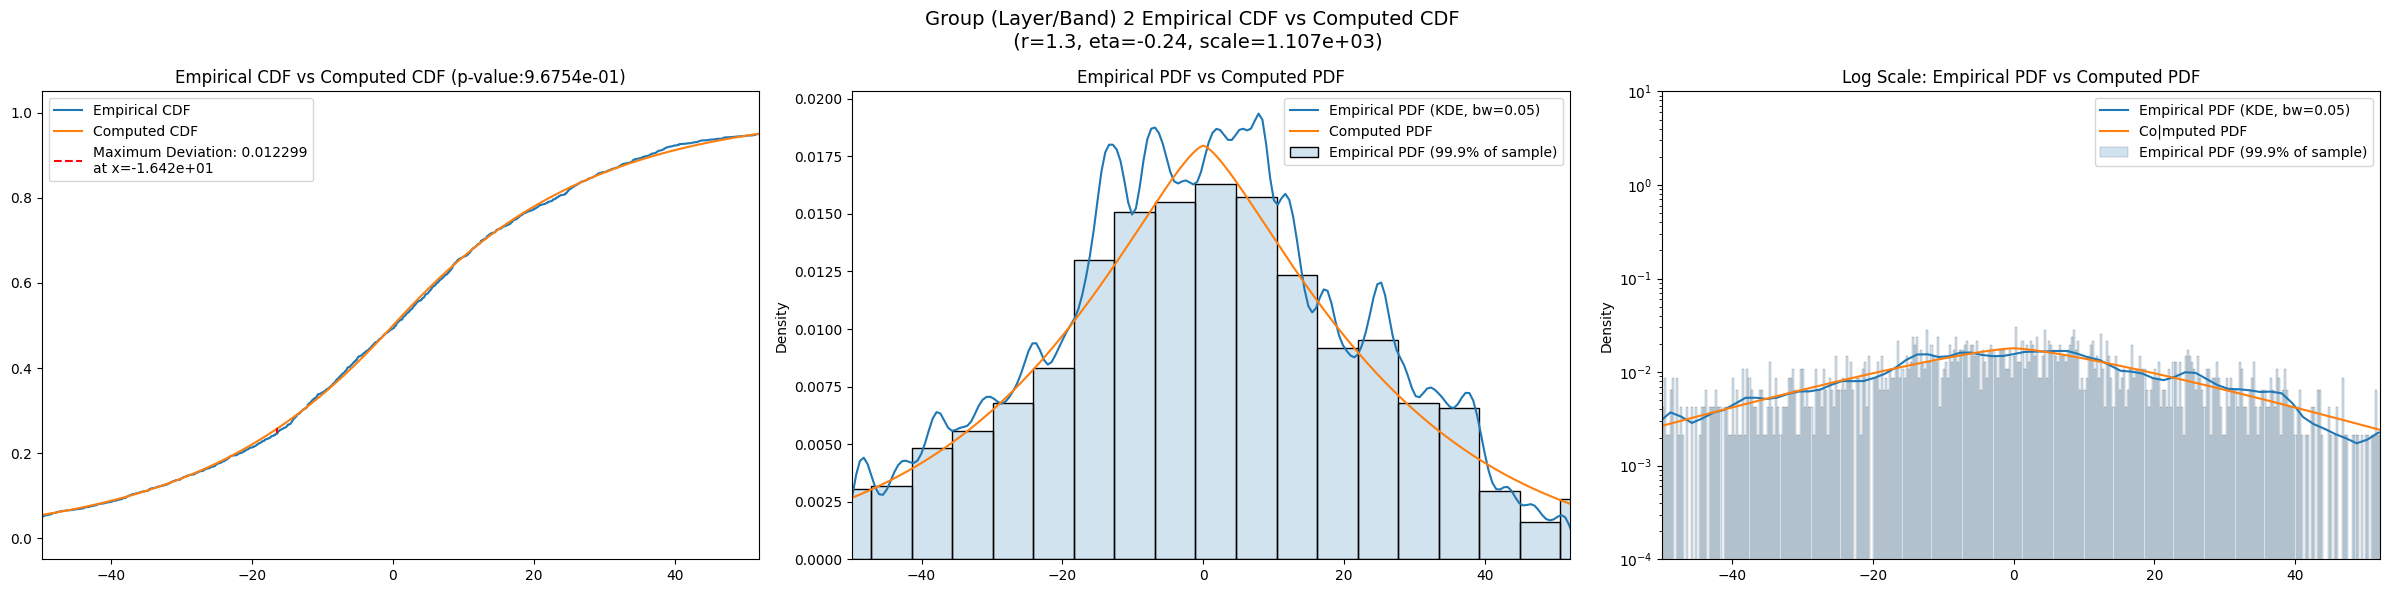

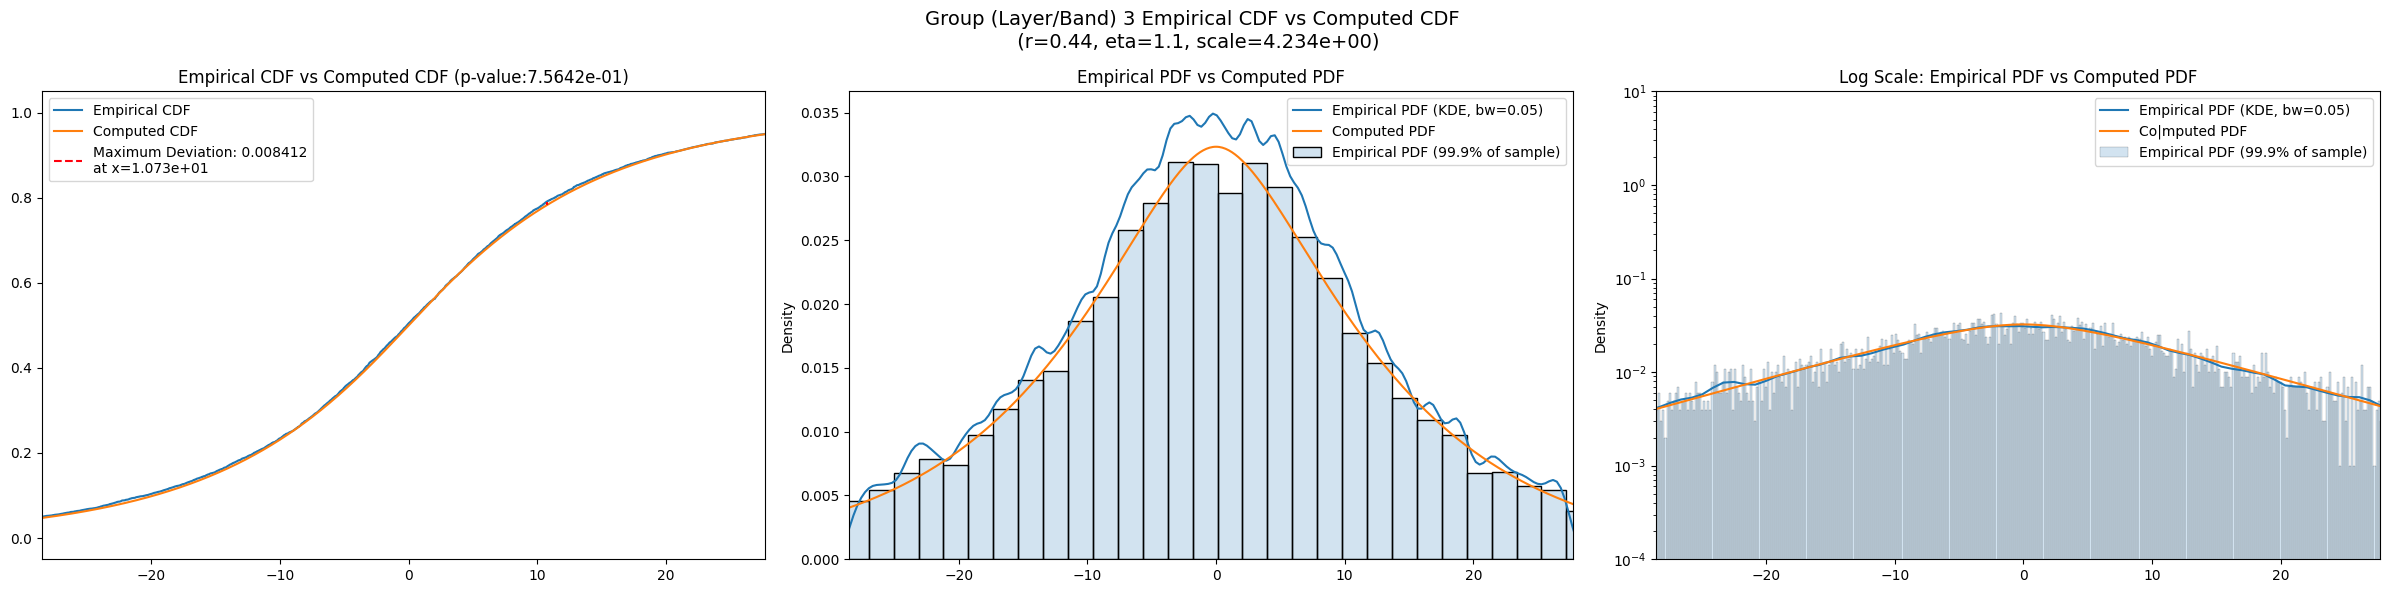

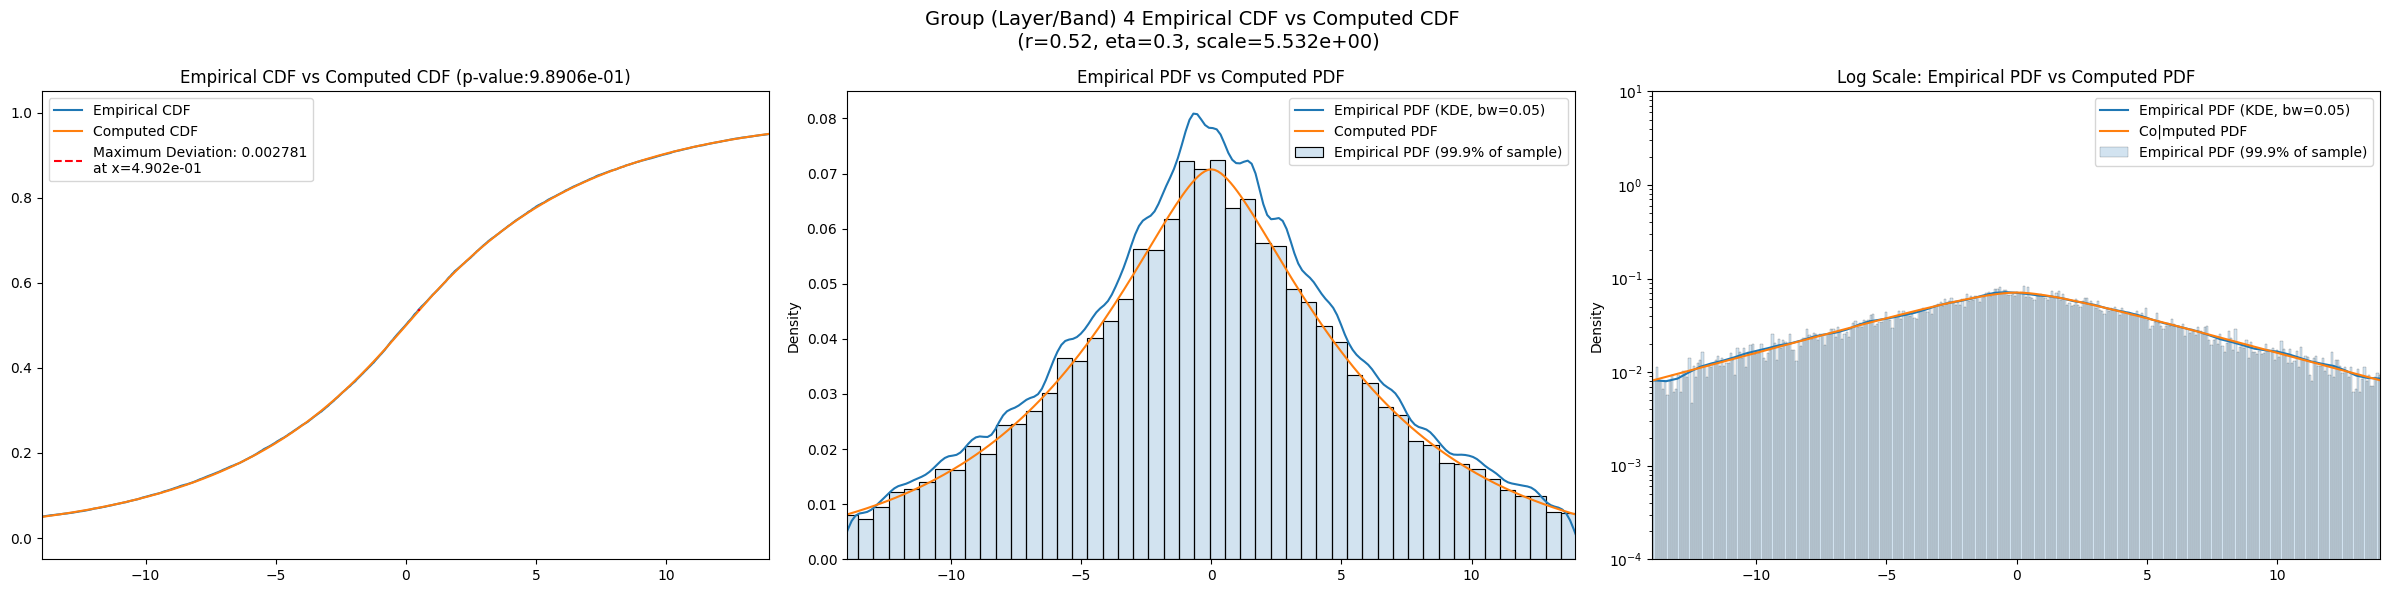

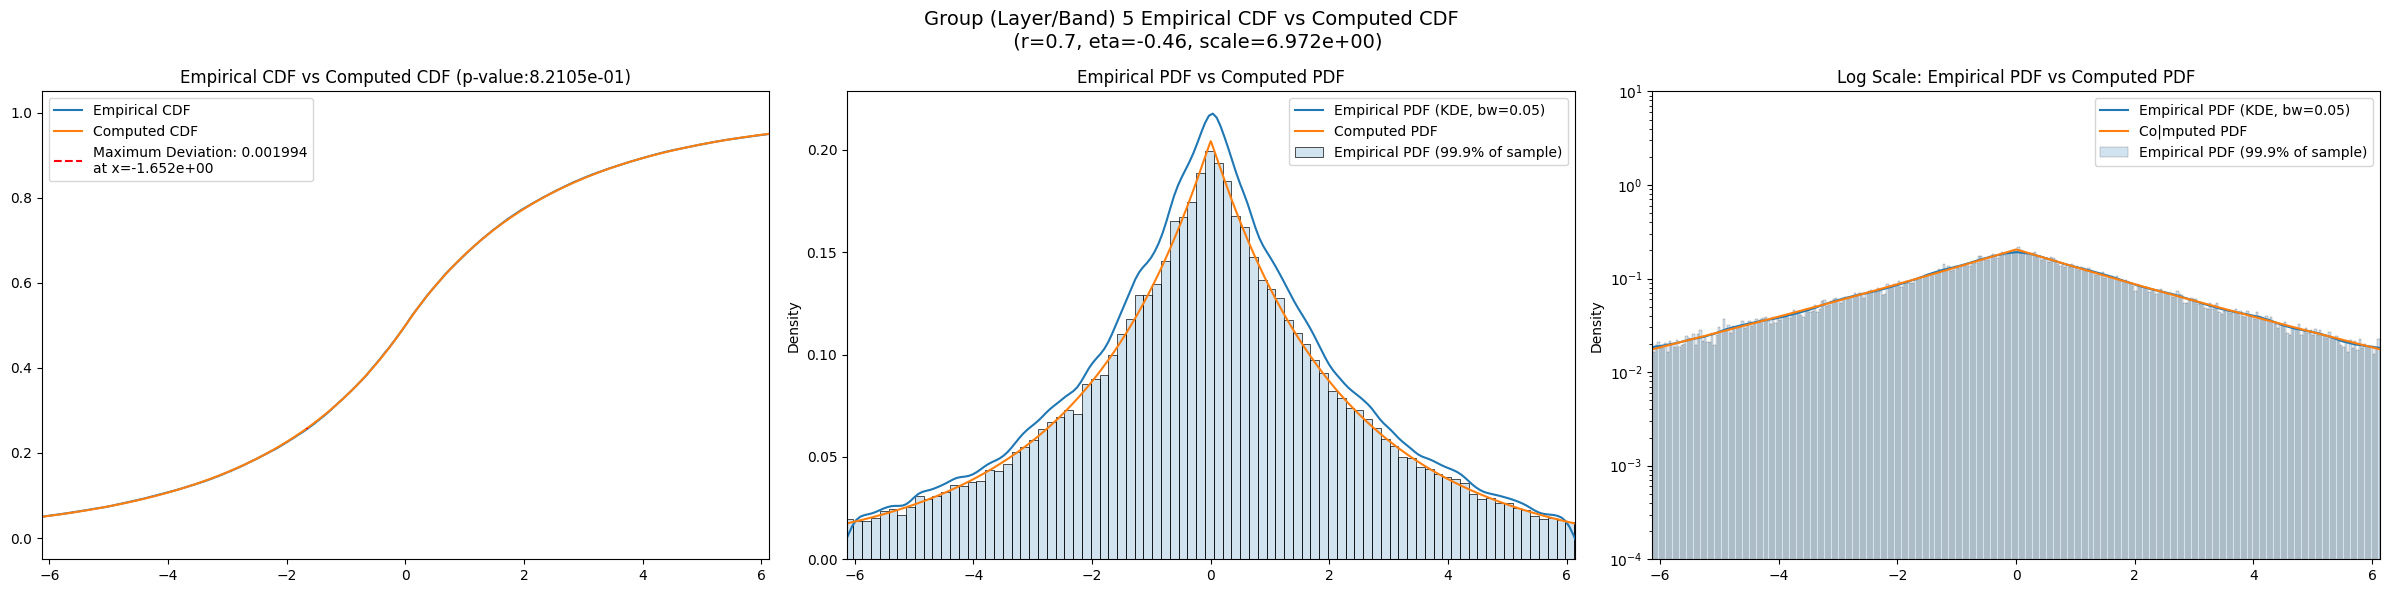

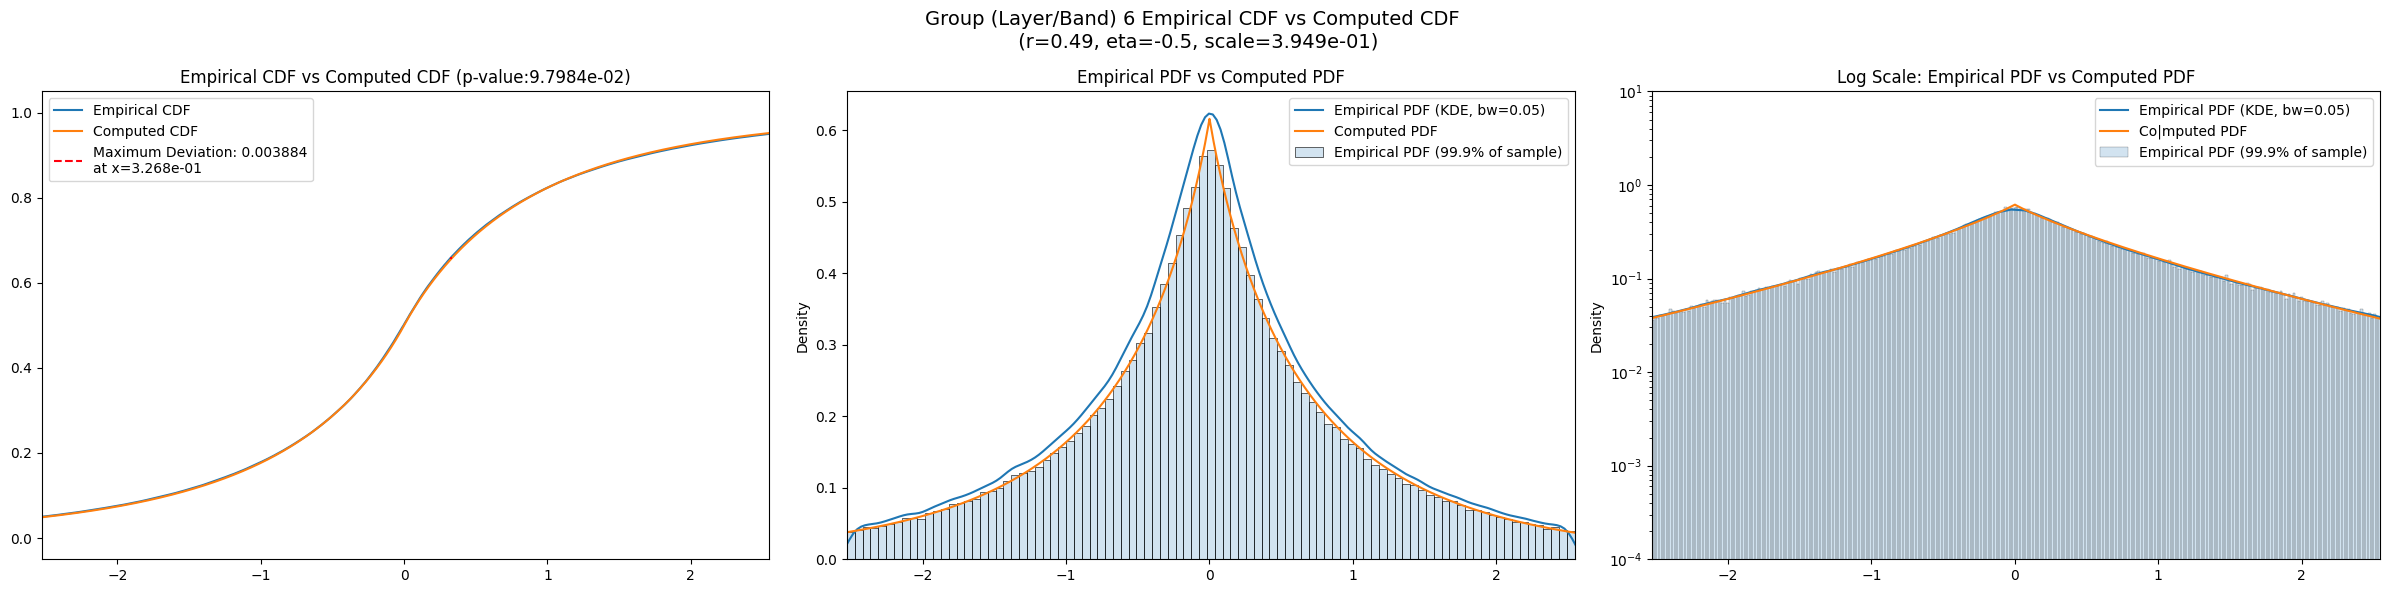

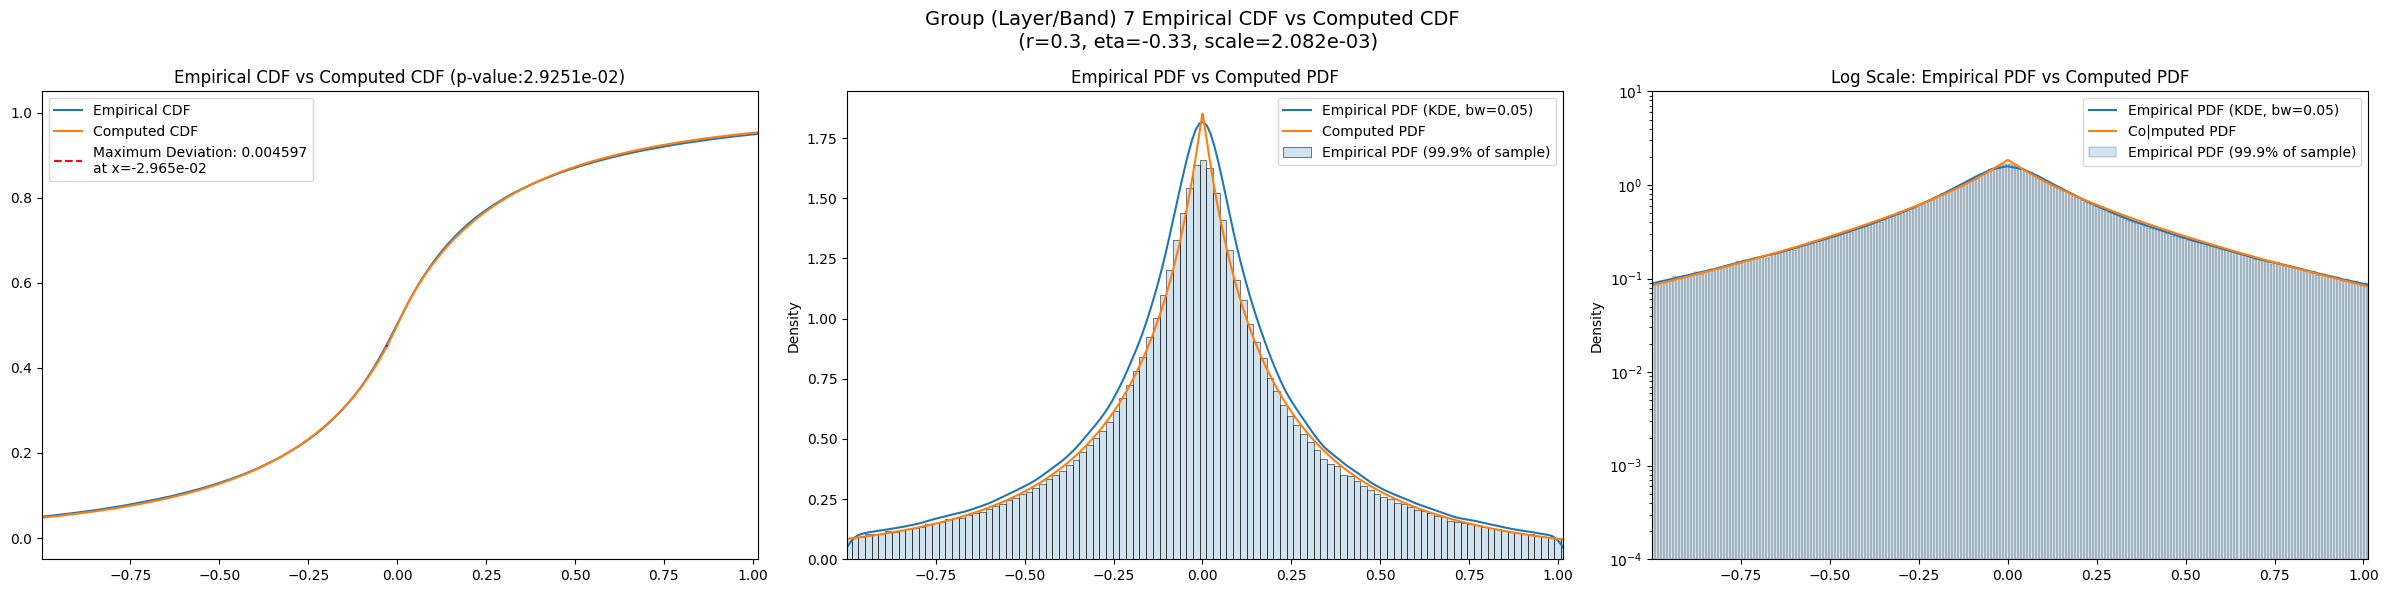

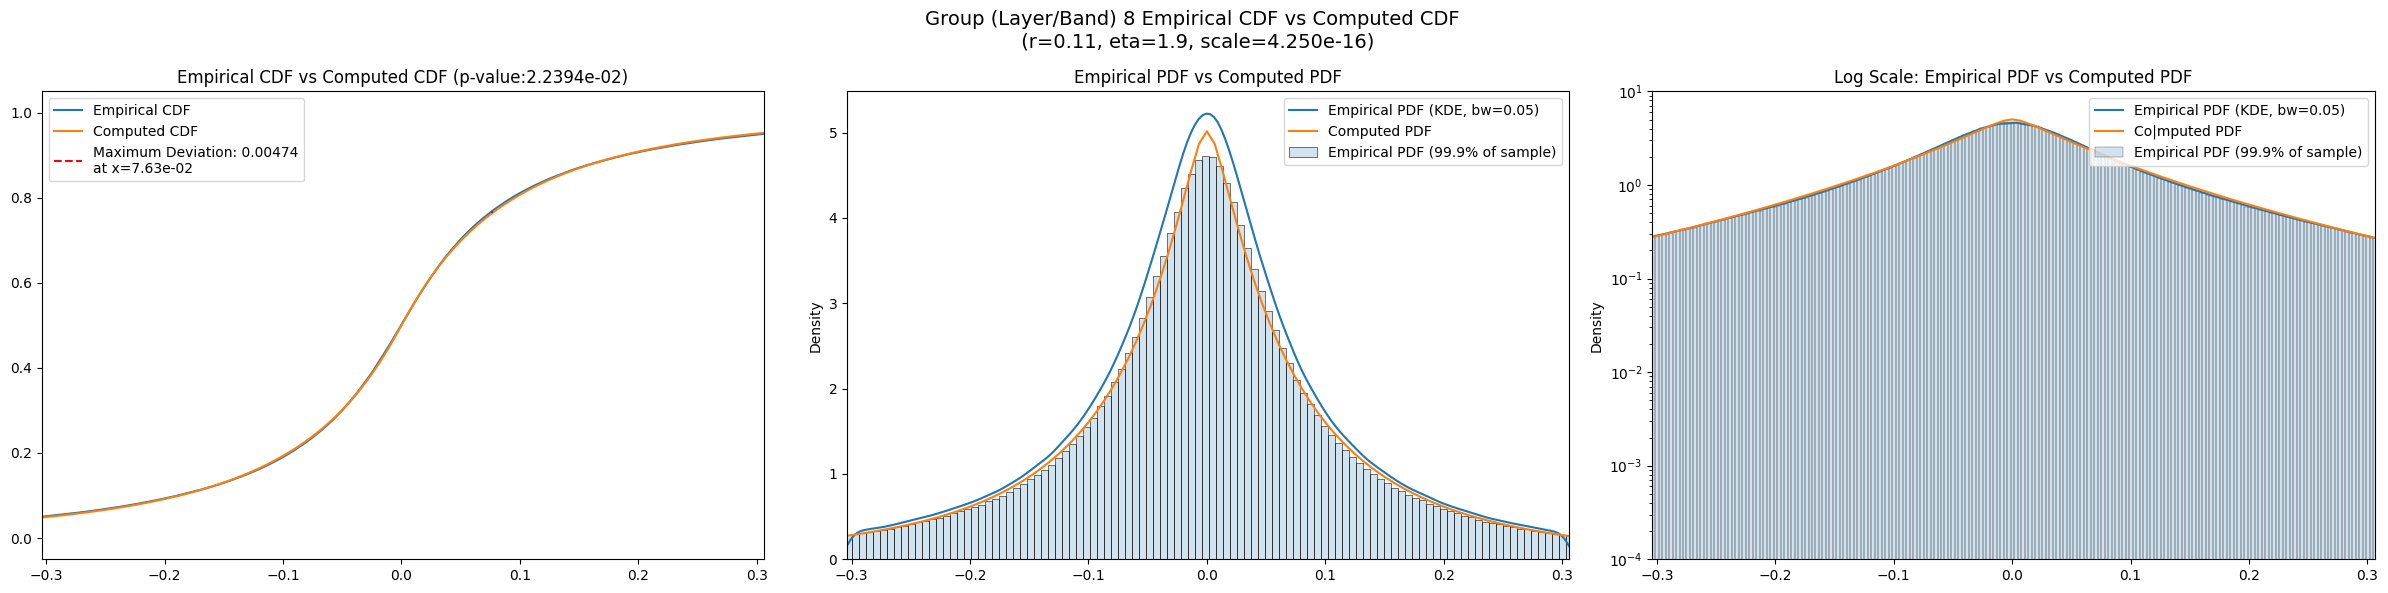

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    #fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    #master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
#master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      995.566040  864.354500  1142.784500   2.687830    1.028233    4.575933   
3      299.988920  279.984800   320.884950   2.454340    1.804920    3.180163   
4       75.562880   71.306270    80.026050   2.987251    2.351555    3.896905   
5       14.565750   13.678300    15.491117   3.872311    3.021069    4.954880   
6        2.581126    2.403492     2.771678   5.708778    4.301481    8.222433   
7        0.439725    0.403006     0.480876   9.534605    6.583607   17.606100   
8        0.044586    0.040037     0.050722  18.418106    8.617492   67.336680   

       total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
layer                                                              ...   
2               1590             0.012170        1.4         -0.3  ...   
3               6360             0.008432        0.5          0.8  ...   
4              25440             0.002853        0.6          0.1  ...   
5             101760             0.002603        0.8         -0.5  ...   
6             407040             0.004151        0.5         -0.5  ...   
7            1628160             0.005992        0.3         -0.3  ...   
8            6512640             0.004613        0.1          2.2  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           26.898500              0.025768          2.376030e-01   
3           14.609100              0.025789          4.161510e-04   
4            7.109990              0.026376          8.295240e-16   
5            2.930290              0.032972          1.503280e-96   
6            1.101230              0.043156          0.000000e+00   
7            0.398454              0.050938          0.000000e+00   
8            0.125055              0.046367          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          24.204900             0.018609         6.336020e-01  19.849900   
3          13.205300             0.015121         1.080100e-01  10.490400   
4           6.256510             0.005810         3.556800e-01   5.087210   
5           2.556230             0.005298         6.578120e-03   2.103480   
6           0.962239             0.015347         1.042840e-83   0.780010   
7           0.349619             0.023293         0.000000e+00   0.279632   
8           0.110061             0.019546         0.000000e+00   0.088350   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.021916   4.237270e-01          9.744392e-01  
3           0.015889   7.973920e-02          7.890863e-01  
4           0.011512   2.340020e-03          9.906279e-01  
5           0.009919   3.993720e-09          9.125816e-01  
6           0.018452  8.197890e-121          1.046689e-05  
7           0.023980   0.000000e+00          7.451021e-31  
8           0.017423   0.000000e+00         3.637124e-113  

[7 rows x 30 columns]

## Results

In [ ]:
import pandas as pd
import os
#master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012170                 0.033952          0.011979   
3                 0.008432                 0.017003          0.008148   
4                 0.002853                 0.008508          0.002743   
5                 0.002603                 0.004256          0.001753   
6                 0.004151                 0.002128          0.003865   
7                 0.005992                 0.001064          0.004638   
8                 0.004613                 0.000532          0.004464   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.025768             0.018609       0.021916  
3                  0.025789             0.015121       0.015889  
4                  0.026376             0.005810       0.011512  
5                  0.032972             0.005298       0.009919  
6                  0.043156             0.015347       0.018452  
7                  0.050938             0.023293       0.023980  
8                  0.046367             0.019546       0.017423

In [ ]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2              995.566040          0.011979    1.30     -0.24  1.106623e+03   
3              299.988922          0.008148    0.44      1.10  4.233649e+00   
4               75.562881          0.002743    0.52      0.30  5.531722e+00   
5               14.565750          0.001753    0.70     -0.46  6.972310e+00   
6                2.581126          0.003865    0.49     -0.50  3.948604e-01   
7                0.439725          0.004638    0.30     -0.33  2.082072e-03   
8                0.044586          0.004464    0.11      1.90  4.250085e-16   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0

In [ ]:
eng.quit()